<a href="https://www.kaggle.com/code/clemwo/competition-eda-house-price-prediction?scriptVersionId=197028250" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import shap        
        
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_context("paper")
shap.initjs()

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


![](https://dynamic-media-cdn.tripadvisor.com/media/photo-o/0f/61/a3/15/iowa-house-on-sw-corner.jpg?w=700&h=-1&s=1)

# 🔥Competition 🏆 EDA & House Price Prediction🏡

This notebooks builds models for Kaggles [Houses Prices 🏡 competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). The objective is to develop a model which predicts the `SalePrice` of a a house. The submission evaluation metric is the _Root Mean Squared Error_ ([RMSE](https://en.wikipedia.org/wiki/Root_mean_square_deviation)) between the logarithm of the predicted value and the logarithm of the observed sales price. The format of the submission file `submission.csv` should be as follows: 
```
    Id,SalePrice
    1461,169000.1
    1462,187724.1233
    1463,175221
    etc.
```

In [2]:
houses = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
print(f"Rows: {houses.shape[0]:,}")
print(f"Cols: {houses.shape[1]:,}")
houses.head(3)

Rows: 1,460
Cols: 81


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
RANDOM_STATE = 42

# General Overview

In [4]:
dtype_groups = houses.columns.to_series().groupby(houses.dtypes).apply(list)

int_cols, float_cols, object_cols = [], [], []

for dtype, columns in dtype_groups.items():
    if dtype == 'int64': int_cols = columns
    elif dtype =='float64': float_cols = columns
    else: object_cols = columns
        
    print(f"There are {len(columns):3} columns of type {dtype}:")
    print(columns)
    print("\n")

There are  35 columns of type int64:
['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


There are   3 columns of type float64:
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


There are  43 columns of type object:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', '

In [5]:
print(houses.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


In [6]:
ID = 'Id'
TARGET = 'SalePrice'

## Numerical Variables

In [7]:
num_features = int_cols + float_cols
num_features = [x for x in num_features if x not in [ID, TARGET]]

In [8]:
temp = houses[num_features]

stats = pd.DataFrame({
    'Variable Name': temp.columns,
    'Missing Count': temp.isnull().sum().values,
    'Missing Rate (%)': 100*temp.isnull().mean().values,
    'Unique Count': temp.nunique().values,
    'Unique Rate (%)': 100*temp.nunique().values / len(temp)
}).sort_values(['Missing Rate (%)'], ascending=False)
stats

,Variable Name,Missing Count,Missing Rate (%),Unique Count,Unique Rate (%)
33,LotFrontage,259,17.739726,110,7.534247
35,GarageYrBlt,81,5.547945,97,6.643836
34,MasVnrArea,8,0.547945,327,22.397260
26,EnclosedPorch,0,0.000000,120,8.219178
20,TotRmsAbvGrd,0,0.000000,12,0.821918
21,Fireplaces,0,0.000000,4,0.273973
22,GarageCars,0,0.000000,5,0.342466
23,GarageArea,0,0.000000,441,30.205479
24,WoodDeckSF,0,0.000000,274,18.767123
25,OpenPorchSF,0,0.000000,202,13.835616


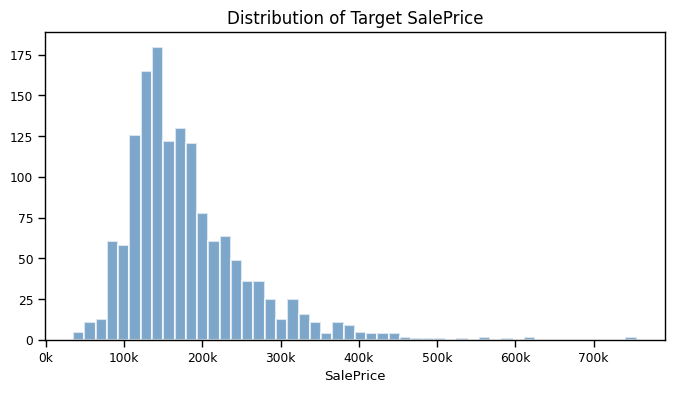

In [9]:
plt.figure(figsize=(8, 4))

plt.hist(houses[TARGET], bins=50, edgecolor='white', linewidth=1.5, color='#4682B4', alpha=0.7);
plt.xlabel(TARGET)
plt.title("Distribution of Target SalePrice", fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{int(y/1_000)}k'))

plt.show()

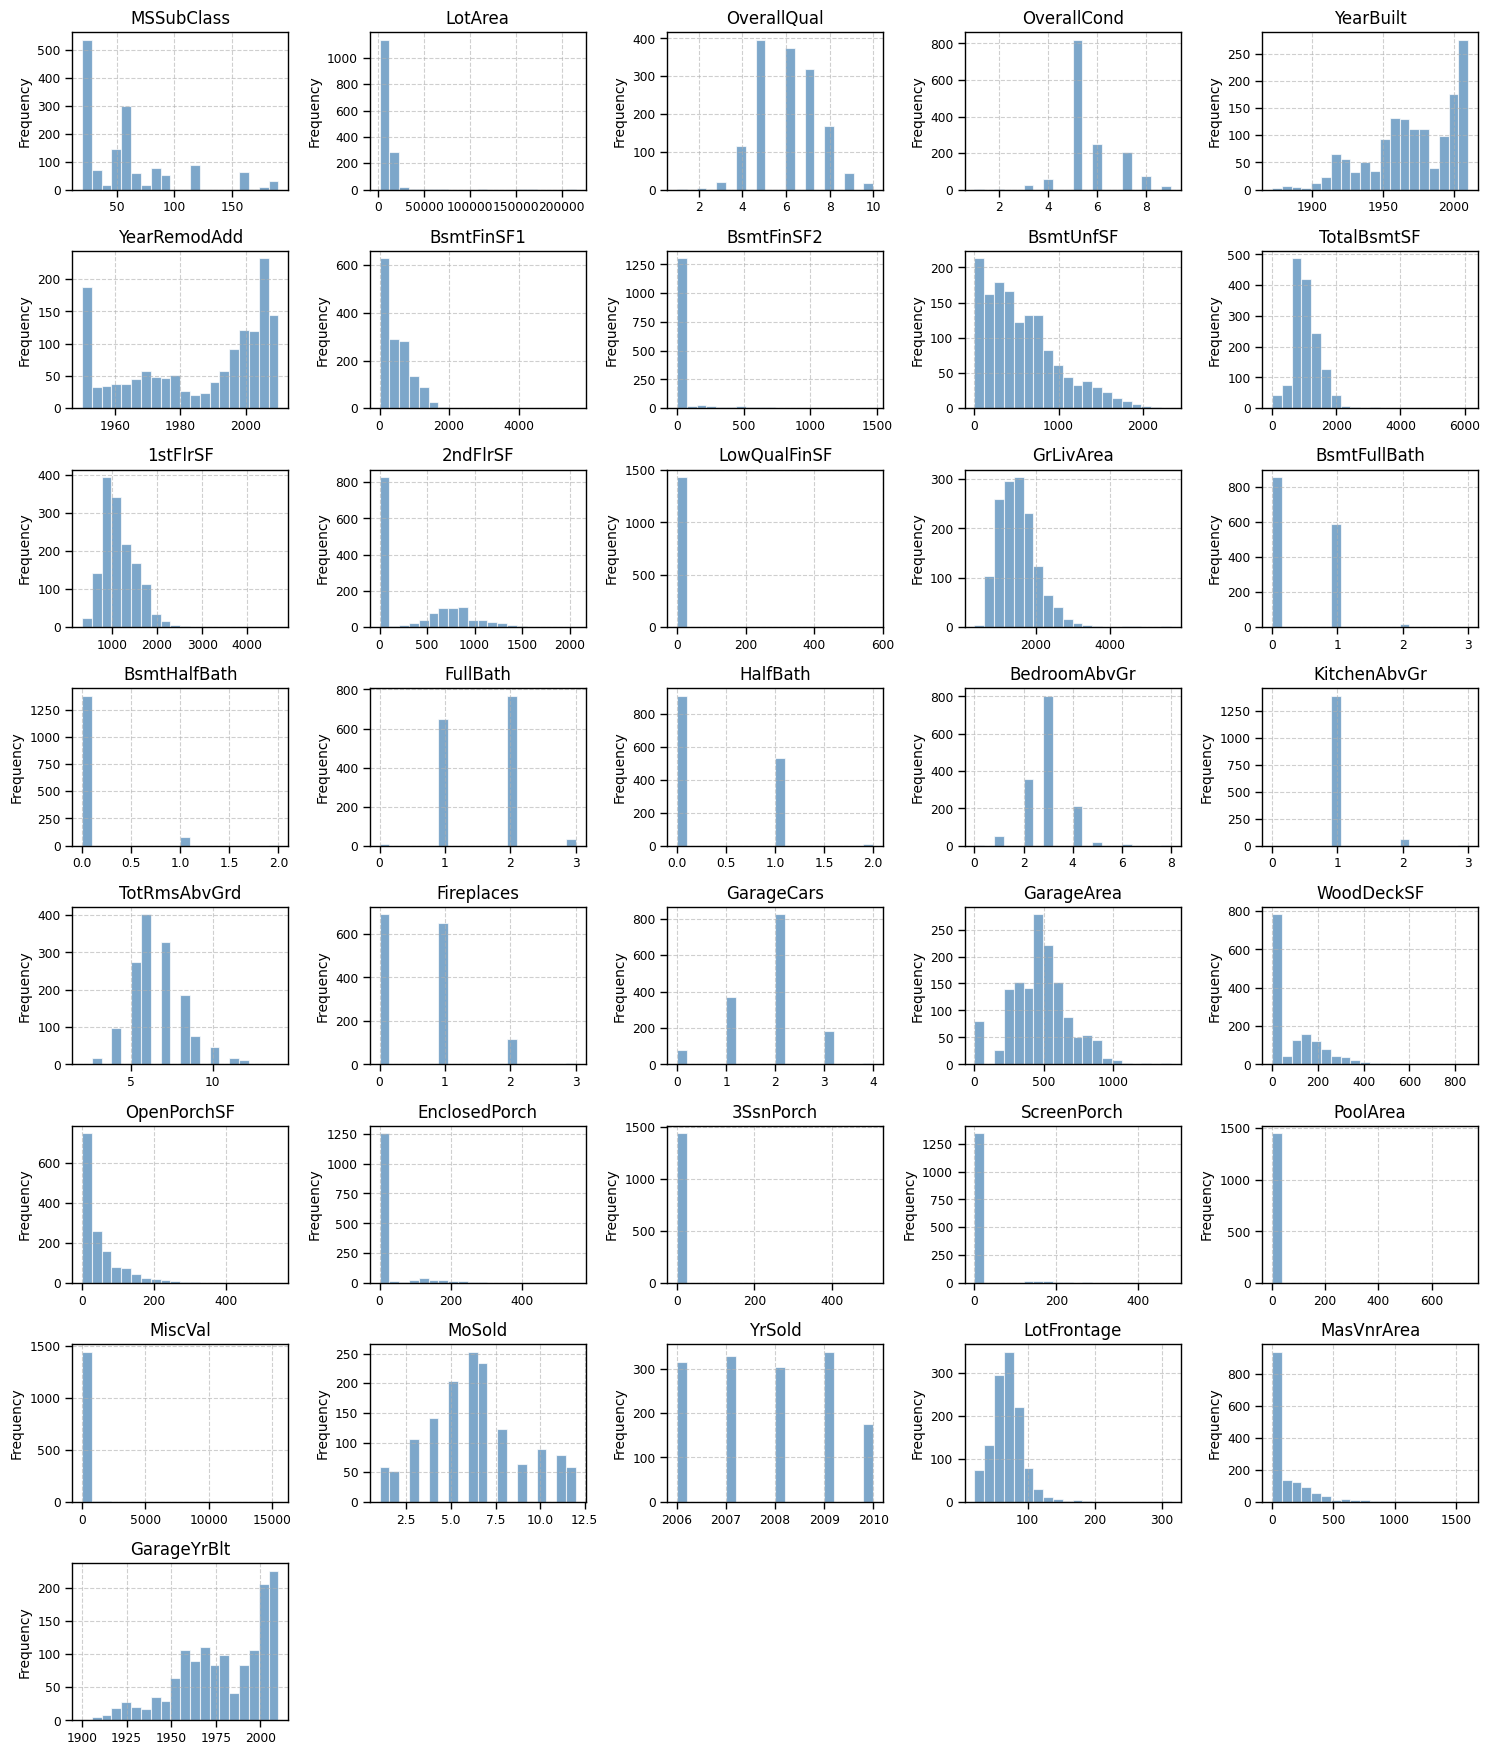

In [10]:
fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(15, 18))

color = '#4682B4'
axes = axes.flatten()

for index, col in enumerate(num_features):
    ax = axes[index]
    ax.hist(houses[col], color=color, bins=20, edgecolor='white', alpha=0.7)
    ax.set_title(f"{col}", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)

for i in range(len(num_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

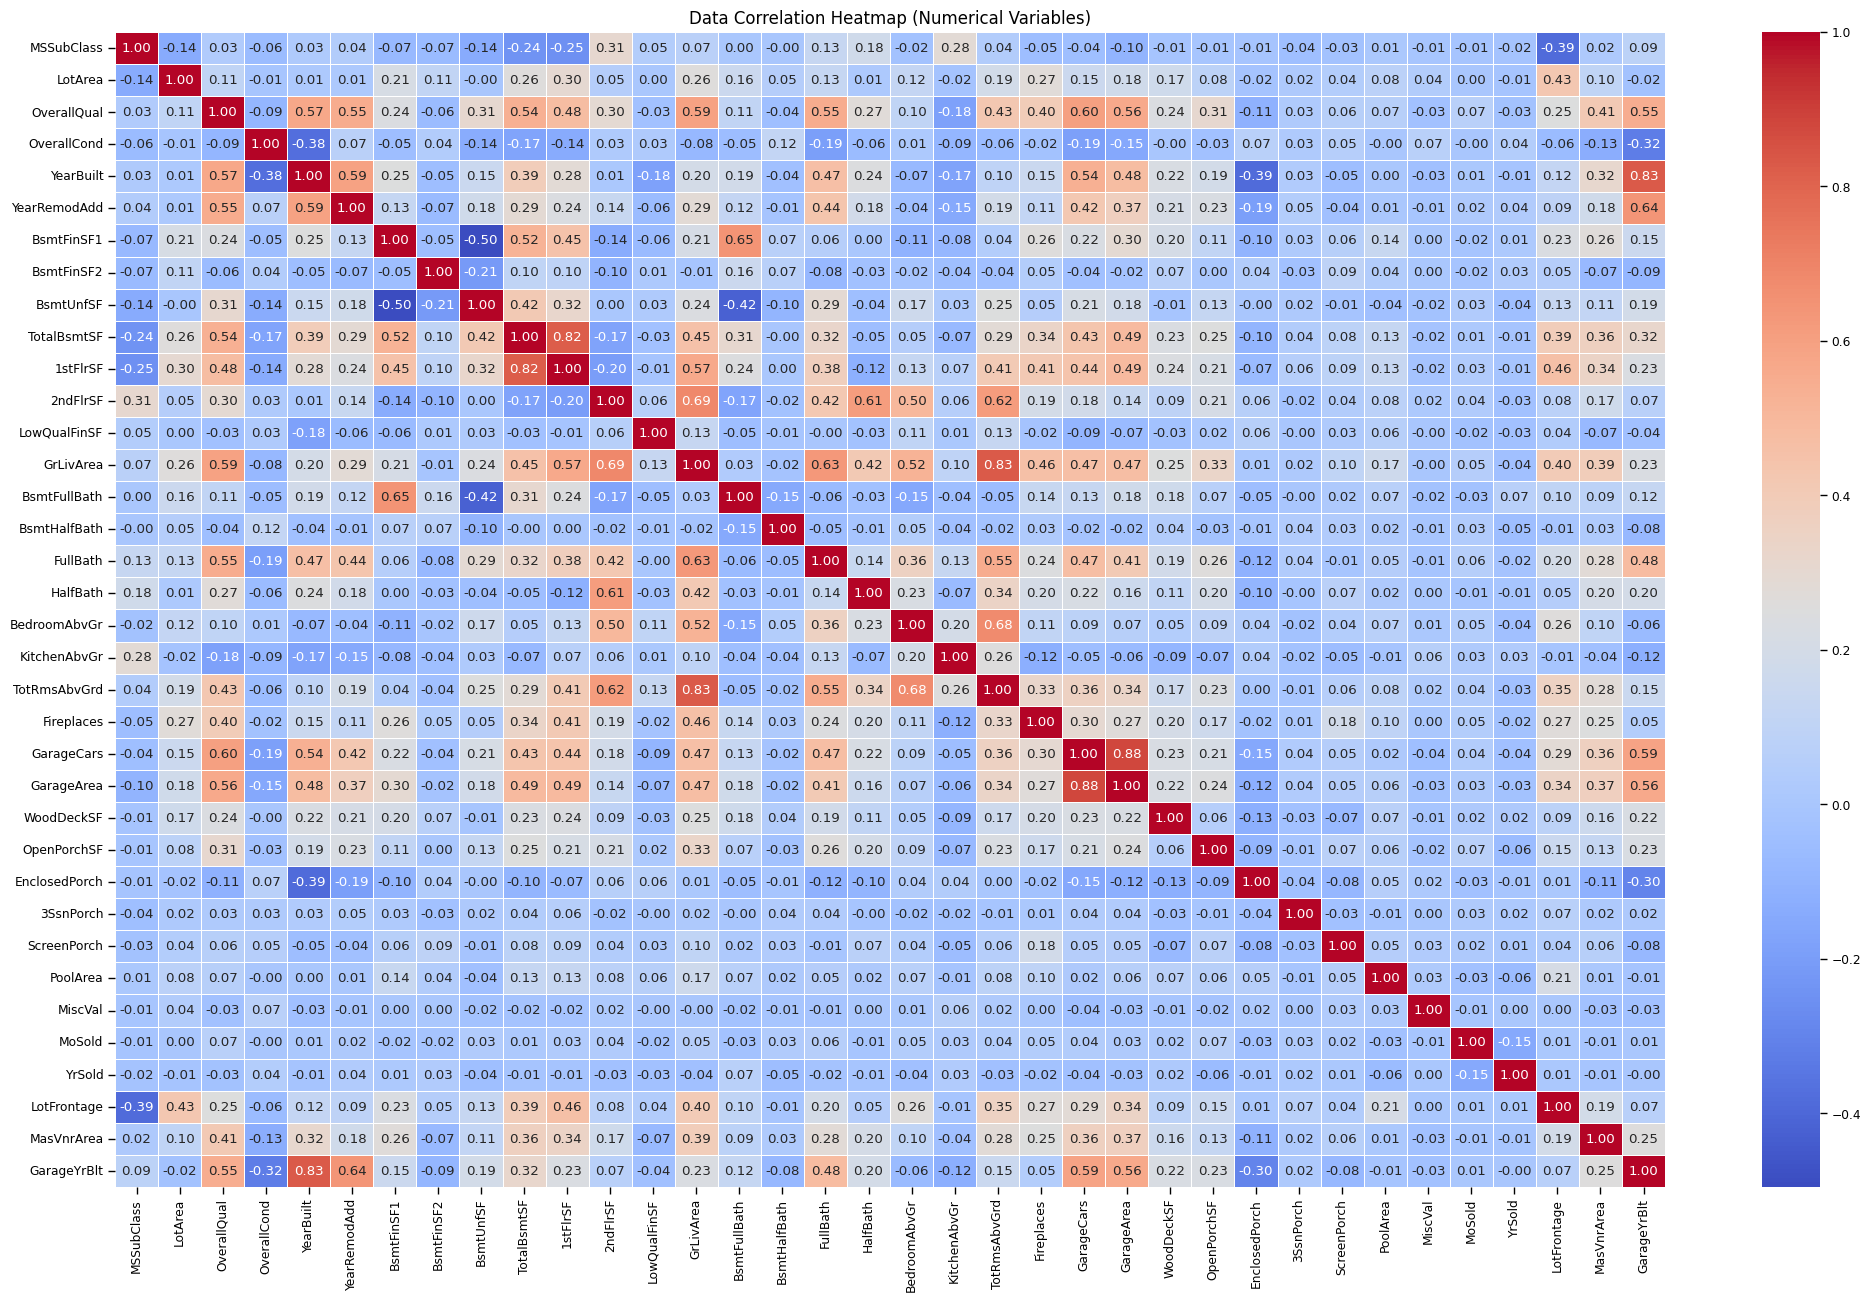

In [11]:
plt.figure(figsize=(25, 15))

sns.heatmap(houses[num_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

plt.title('Data Correlation Heatmap (Numerical Variables)', fontsize=12)
plt.show()

## Categorical Variables

In [12]:
temp = houses[object_cols].copy()

stats = pd.DataFrame({
    'Variable Name': temp.columns,
    'Missing Count': temp.isnull().sum().values,
    'Missing Rate (%)': 100*temp.isnull().mean().values,
    'Unique Count': temp.nunique().values,
    'Unique Rate (%)': 100*temp.nunique().values / len(temp)
}).sort_values(['Missing Rate (%)'], ascending=False)
stats

,Variable Name,Missing Count,Missing Rate (%),Unique Count,Unique Rate (%)
38,PoolQC,1453,99.520548,3,0.205479
40,MiscFeature,1406,96.301370,4,0.273973
2,Alley,1369,93.767123,2,0.136986
39,Fence,1179,80.753425,4,0.273973
17,MasVnrType,872,59.726027,3,0.205479
32,FireplaceQu,690,47.260274,5,0.342466
33,GarageType,81,5.547945,6,0.410959
36,GarageCond,81,5.547945,5,0.342466
35,GarageQual,81,5.547945,5,0.342466
34,GarageFinish,81,5.547945,3,0.205479


There are quiet some variables with missing values. We need to handle these before we apply label encoding. 

In [13]:
def handle_missing_values(data, object_cols, strategy='fill_missing'):
    """Handle missing values in categorical features."""
    for col in object_cols:
        if strategy == 'fill_missing':
            data[col] = data[col].fillna('Missing')
        elif strategy == 'most_frequent':
            most_frequent = data[col].mode()[0]
            data[col] = data[col].fillna(most_frequent)
    return data

In [14]:
houses = handle_missing_values(houses, object_cols, strategy='fill_missing')

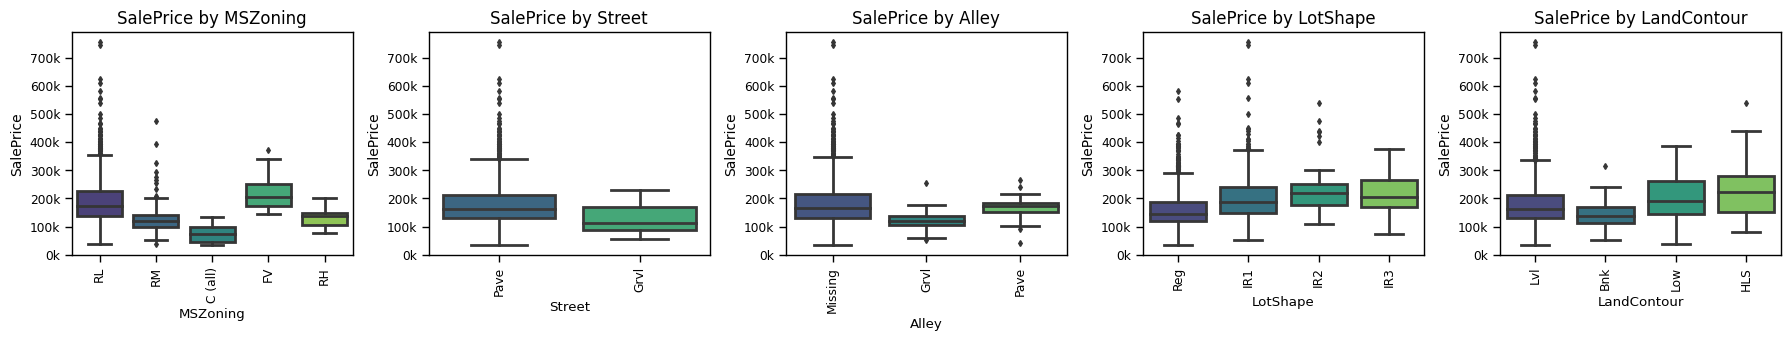

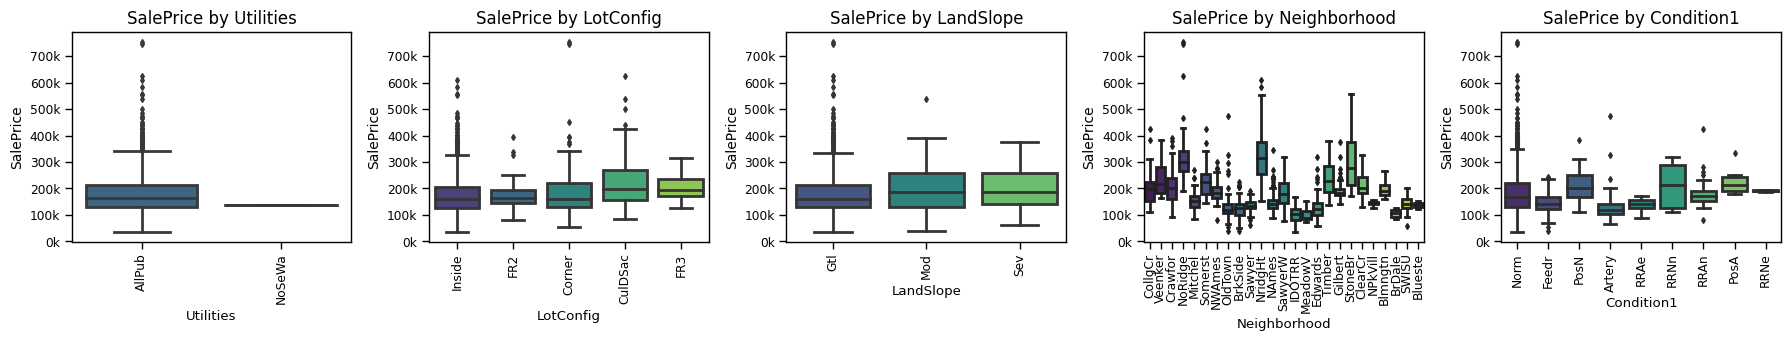

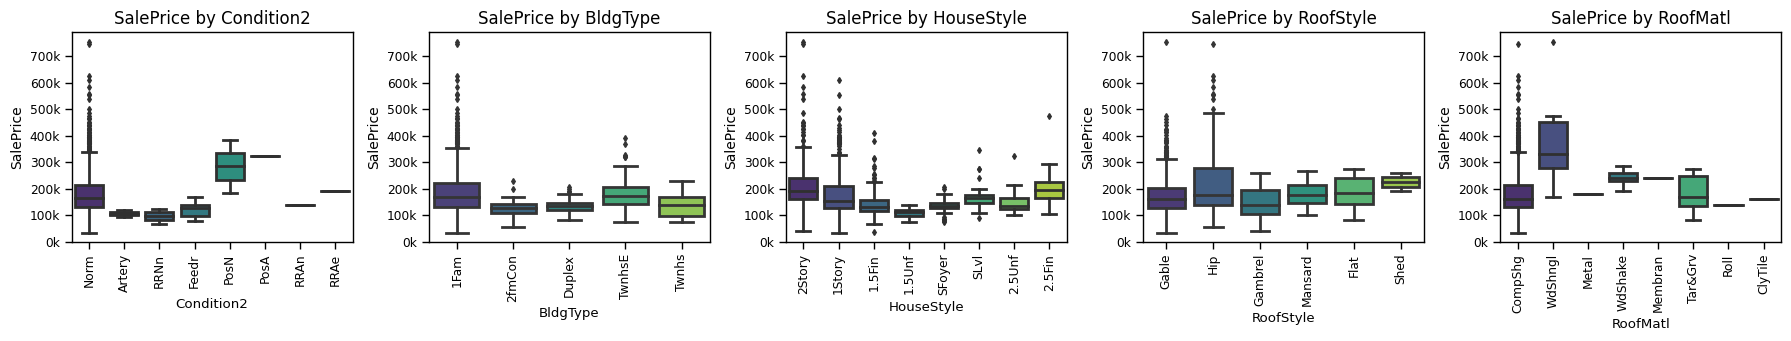

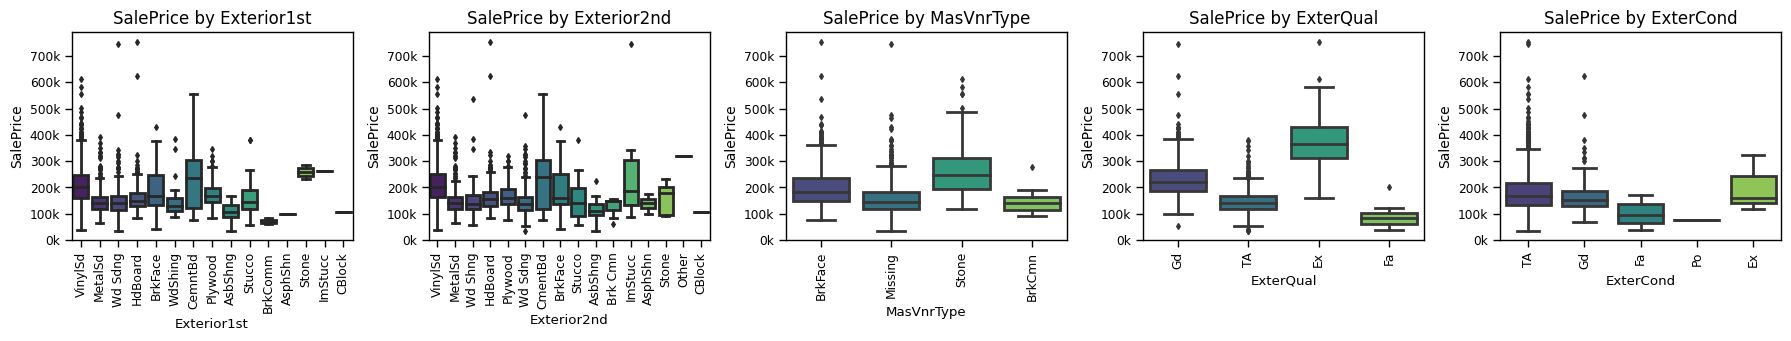

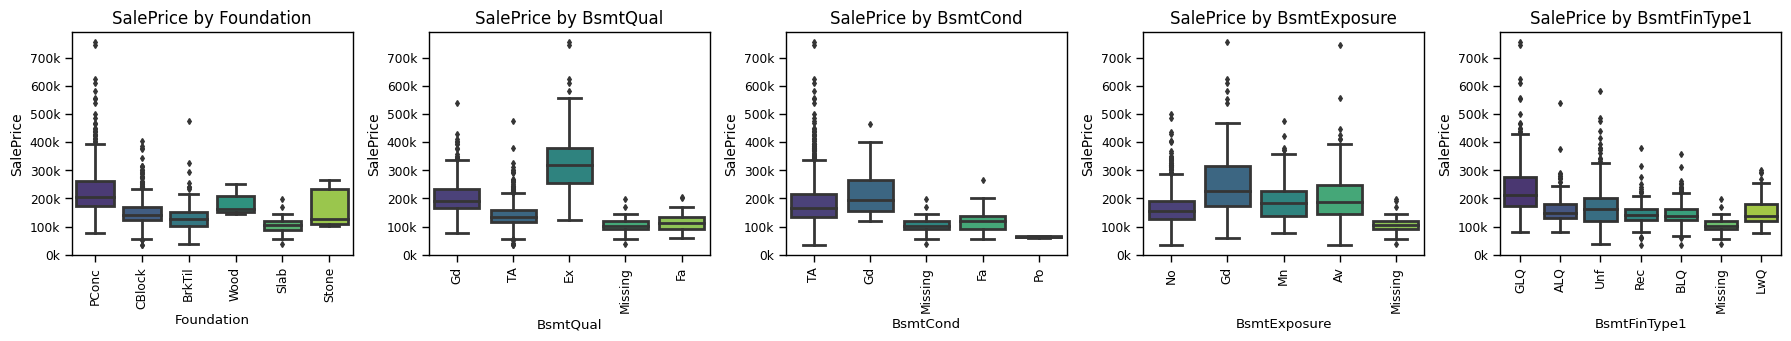

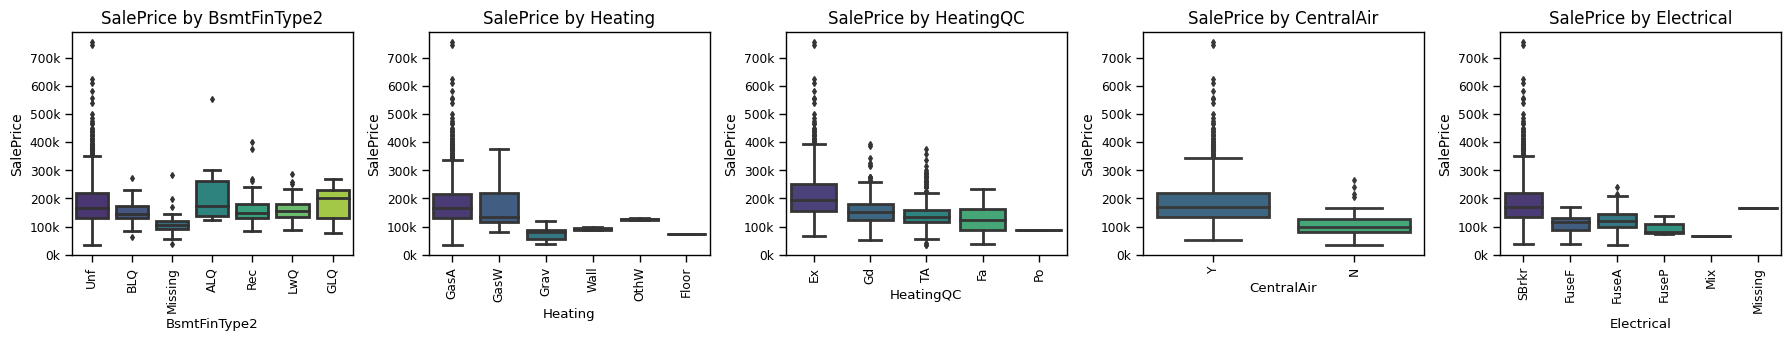

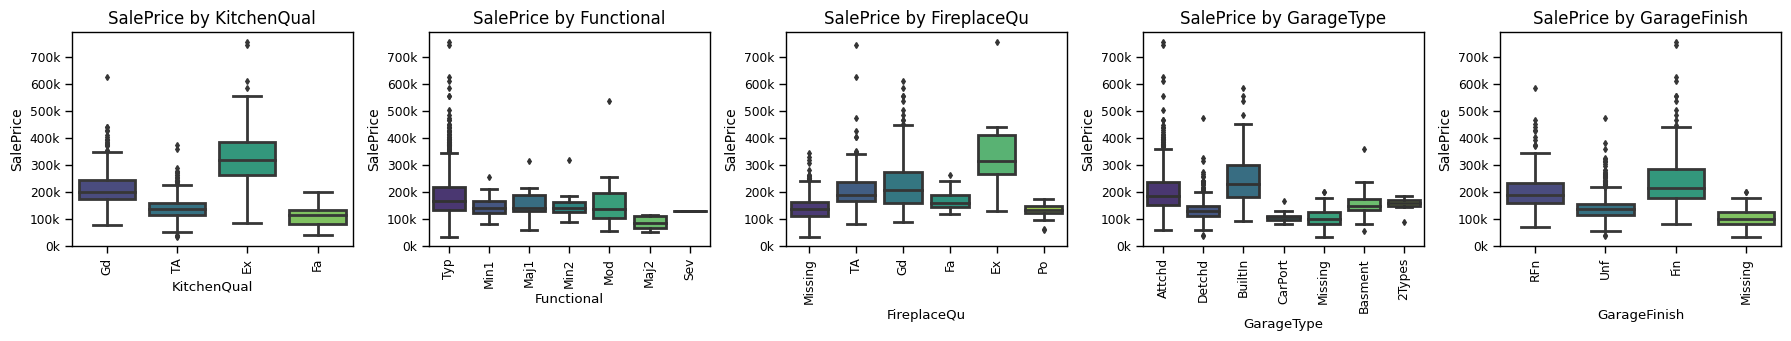

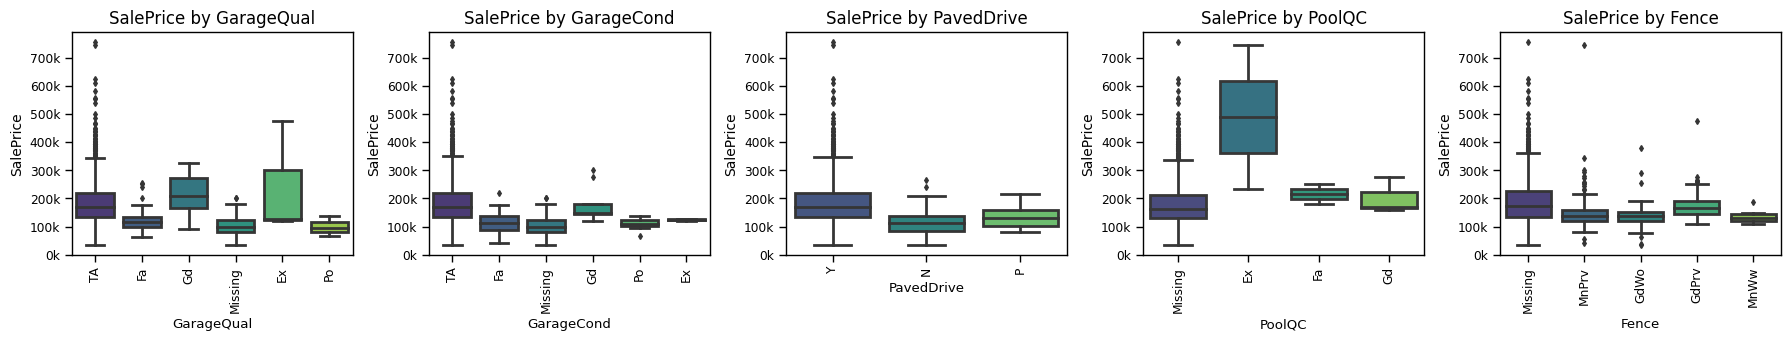

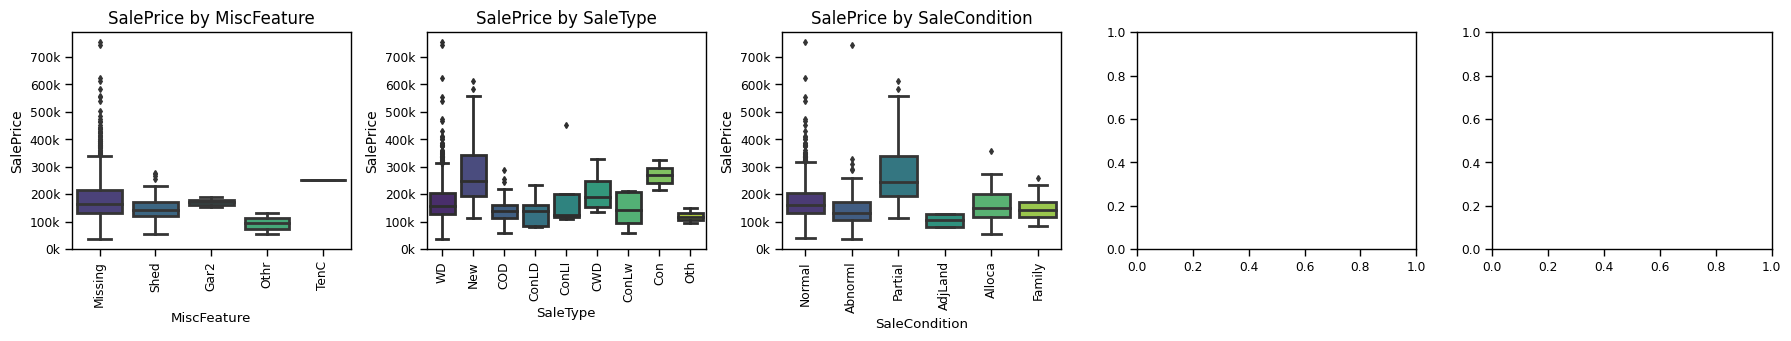

In [15]:
num_cols = len(object_cols)
num_plots = 5 

for i in range(0, num_cols, num_plots):
    fig, axes = plt.subplots(1, num_plots, figsize=(18, 3.5))

    for j, col in enumerate(object_cols[i:i+num_plots]):
        ax = axes[j]

        sns.boxplot(x=houses[col], y=houses[TARGET], ax=ax, linewidth=2, fliersize=3, palette='viridis')

        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{int(y/1_000)}k'))

        ax.set_title(f"{TARGET} by {col}", fontsize=12)
        ax.set_ylabel(TARGET, fontsize=10)

    plt.tight_layout()
    plt.show()

In [16]:
def label_encode_features(data, object_cols):
    """Label encode categorical features and add them as new columns with prefix 'le_'."""

    label_encoders = {}
    encoded_features = []
    
    for col in object_cols:
        label_encoders[col] = LabelEncoder()
        encoded_col_name = f'le_{col}'
        data[encoded_col_name] = label_encoders[col].fit_transform(data[col].astype(str))
        
        encoded_features.append(encoded_col_name)
        
    return {
        'data': data,
        'encoded_features': encoded_features,
        'label_encoder': label_encoders
    }

le_result = label_encode_features(houses, object_cols)

houses = le_result.get('data').copy()
houses[le_result.get('encoded_features')].head(3)

,le_MSZoning,le_Street,le_Alley,le_LotShape,le_LandContour,le_Utilities,le_LotConfig,le_LandSlope,le_Neighborhood,le_Condition1,...,le_GarageType,le_GarageFinish,le_GarageQual,le_GarageCond,le_PavedDrive,le_PoolQC,le_Fence,le_MiscFeature,le_SaleType,le_SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,1,2,5,5,2,3,2,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,1,2,5,5,2,3,2,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,1,2,5,5,2,3,2,1,8,4


In [17]:
cat_features = le_result.get('encoded_features')

# Preparation

In the following we are going to call the "classical" test set `out-of-bag` (OOB in short). The reason for this is simply that the "actual" test set is the one which we will submit for this competition. 

In [18]:
features = num_features + cat_features
features = [x for x in features if x not in [ID, TARGET]]

In [19]:
X = houses[features]
y = houses[TARGET]

X_train, X_oob, y_train, y_oob = train_test_split(X, y, 
                                                    test_size=0.2, random_state=RANDOM_STATE)

preprocessing_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())                  # Scale numeric features
])

X_train_scaled = preprocessing_pipeline.fit_transform(X_train)
X_oob_scaled = preprocessing_pipeline.transform(X_oob)

# Modeling

In [20]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Required optimization metric for this competition.
    random_state=RANDOM_STATE,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=2.0,
    early_stopping_rounds=50
)

In [21]:
kf = KFold(n_splits=5, 
           shuffle=True, 
           random_state=RANDOM_STATE)

# Track RMSE per fold.
train_rmse_per_fold = []
val_rmse_per_fold = []

# Track predictions per fold.
train_predictions = []
val_predictions = []

# KFold Cross-Validation.
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled)):
    X_train_cv, X_val_cv = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    xgb_model.fit(X_train_cv, y_train_cv, eval_set=[(X_val_cv, y_val_cv)], verbose=False)
    
    # Predict on training and validation.
    y_train_pred = xgb_model.predict(X_train_cv)
    y_val_pred = xgb_model.predict(X_val_cv)
    
    # Track predictions.
    train_predictions.append(y_train_pred)
    val_predictions.append(y_val_pred)
    
    # Calculate RMSE.
    train_rmse = np.sqrt(mean_squared_error(y_train_cv, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_cv, y_val_pred))
    
    # Track RMSE.
    train_rmse_per_fold.append(train_rmse)
    val_rmse_per_fold.append(val_rmse)
    
    print(f"Fold {fold+1} -> Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")

Fold 1 -> Train RMSE: 1831.1183, Validation RMSE: 27563.7706
Fold 2 -> Train RMSE: 3523.7257, Validation RMSE: 30240.7956
Fold 3 -> Train RMSE: 1111.3195, Validation RMSE: 30131.6228
Fold 4 -> Train RMSE: 1407.9708, Validation RMSE: 23086.1474
Fold 5 -> Train RMSE: 3907.8085, Validation RMSE: 22642.8829


In [22]:
train_mu, train_sd = np.mean(train_rmse_per_fold), np.std(train_rmse_per_fold)
val_mu, val_sd = np.mean(val_rmse_per_fold), np.std(val_rmse_per_fold)
print(f"Training   RMSE: {train_mu:>7.2f} +- {train_sd:>7.2f}")
print(f"Validation RMSE: {val_mu:>7.2f} +- {val_sd:>7.2f}")

Training   RMSE: 2356.39 +- 1139.75
Validation RMSE: 26733.04 +- 3303.76


In [23]:
train_predictions = np.concatenate(train_predictions)
val_predictions = np.concatenate(val_predictions)

In [24]:
# Evaluate on oob set.
y_oob_pred = xgb_model.predict(X_oob_scaled)
oob_rmse = np.sqrt(mean_squared_error(y_oob, y_oob_pred))
print(f"OOB RMSE: {oob_rmse:.4f}")

OOB RMSE: 25307.6583


In [25]:
train_predictions_clean = np.where(np.isinf(train_predictions), np.nan, train_predictions)
val_predictions_clean = np.where(np.isinf(val_predictions), np.nan, val_predictions)

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


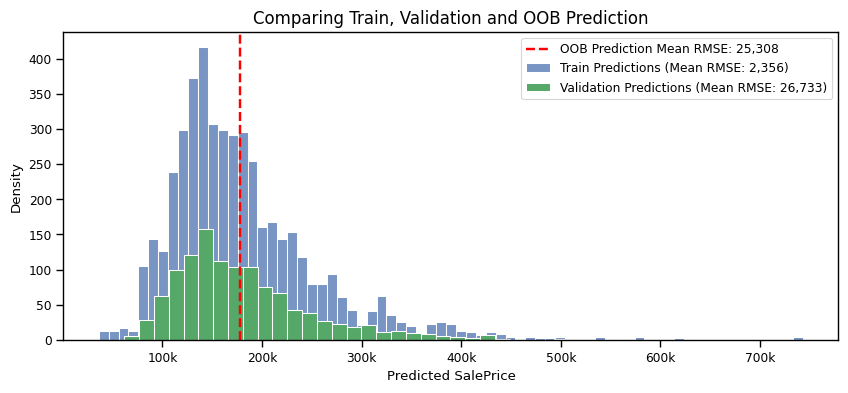

Fold 1 -> Train RMSE: 1831.1183, Validation RMSE: 27563.7706
Fold 2 -> Train RMSE: 3523.7257, Validation RMSE: 30240.7956
Fold 3 -> Train RMSE: 1111.3195, Validation RMSE: 30131.6228
Fold 4 -> Train RMSE: 1407.9708, Validation RMSE: 23086.1474
Fold 5 -> Train RMSE: 3907.8085, Validation RMSE: 22642.8829


In [26]:
# --------------------------------------------------------- #
# Confidence Intervals for Train and Validation Predictions #
# --------------------------------------------------------- #

plt.figure(figsize=(10, 4))

sns.histplot(train_predictions_clean, kde=False, 
             color="#4C72B0", linewidth=.75, edgecolor='white', alpha=0.75, fill=True,
             label=f"Train Predictions (Mean RMSE: {train_mu:,.0f})")
sns.histplot(val_predictions_clean, kde=False, 
             color="#55A868", linewidth=.75, edgecolor='white', alpha=1.0, fill=True,
             label=f"Validation Predictions (Mean RMSE: {val_mu:,.0f})")

plt.axvline(np.mean(y_oob_pred), color="red", linestyle="--", linewidth=1.75, label=f"OOB Prediction Mean RMSE: {oob_rmse:,.0f}")

plt.title("Comparing Train, Validation and OOB Prediction", fontsize=12)
plt.xlabel("Predicted SalePrice")
plt.ylabel("Density")
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{int(y/1_000)}k'))

plt.show()

# Display Train/Validation RMSE per fold.
for i, (train_rmse, val_rmse) in enumerate(zip(train_rmse_per_fold, val_rmse_per_fold), 1):
    print(f"Fold {i} -> Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")

In [27]:
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_oob = xgb_model.predict(X_oob_scaled)

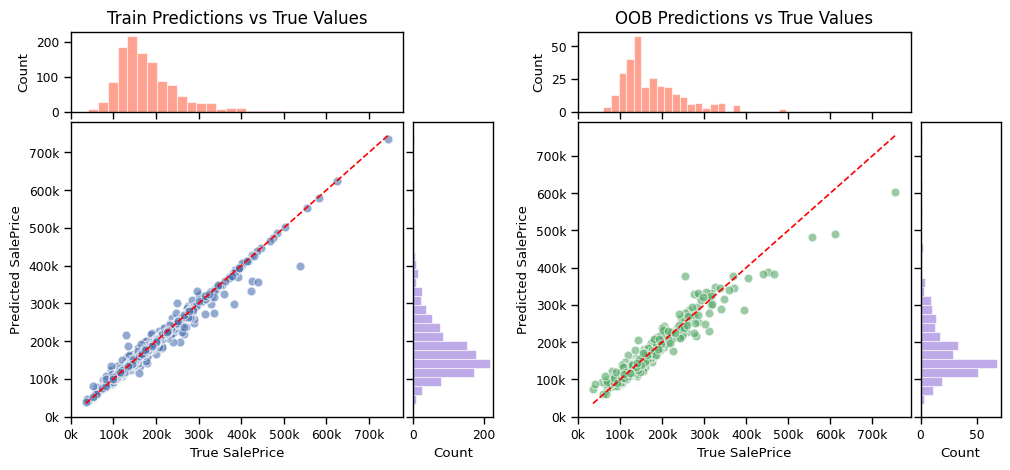

In [28]:
def plot_with_histograms(y_train, y_pred_train, y_oob, y_pred_oob):
    """Plots train and oob predictions with histograms on the right and top."""
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Train Predictions vs True Values ---
    ax = axes[0]
    ax.scatter(y_train, y_pred_train, color="#4C72B0", alpha=0.6, s=40, edgecolor='white')
    ax.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], '--', color='red')
    ax.set_xlabel("True SalePrice")
    ax.set_ylabel("Predicted SalePrice")

    # --- OOB Predictions vs True Values ---
    ax = axes[1]
    ax.scatter(y_oob, y_pred_oob, color="#55A868", alpha=0.6, s=40, edgecolor='white')
    ax.plot([min(y_oob), max(y_oob)], [min(y_oob), max(y_oob)], '--', color='red')
    ax.set_xlabel("True SalePrice")
    ax.set_ylabel("Predicted SalePrice")

    for ax in axes:
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{int(y/1_000)}k'))

    for i, (ax, (y_true, y_pred)) in enumerate(zip(axes, [(y_train, y_pred_train), (y_oob, y_pred_oob)])):
        divider = make_axes_locatable(ax)
        
        ax_histx = divider.append_axes("top", 0.8, pad=0.1, sharex=ax)
        ax_histx.hist(y_pred, bins=30, color='#FF6347', alpha=0.6, edgecolor='white')
        ax_histx.set_ylabel('Count')
        ax_histx.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))
        
        ax_histy = divider.append_axes("right", 0.8, pad=0.1, sharey=ax)
        ax_histy.hist(y_true, bins=30, color='#9370DB', alpha=0.6, orientation='horizontal', edgecolor='white')
        ax_histy.set_xlabel('Count')
        ax_histy.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{int(y/1_000)}k'))
        
        if i == 0: 
            ax_histx.set_title('Train Predictions vs True Values', fontsize=12)
        if i == 1:
            ax_histx.set_title('OOB Predictions vs True Values', fontsize=12)
        
        plt.setp(ax_histx.get_xticklabels(), visible=False)
        plt.setp(ax_histy.get_yticklabels(), visible=False)


plot_with_histograms(y_train, y_pred_train, y_oob, y_pred_oob)

Let's take a look at the spread of errors. 

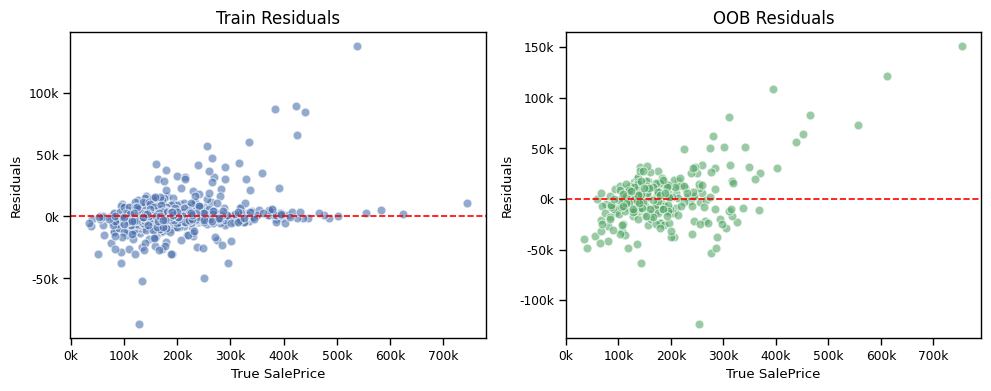

In [29]:
def plot_residuals(y_true_train, y_pred_train, y_true_oob, y_pred_oob):
    residuals_train = y_true_train - y_pred_train
    residuals_oob = y_true_oob - y_pred_oob

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- Train Residuals ---
    axes[0].scatter(y_true_train, residuals_train, color="#4C72B0", s=40, edgecolor='white', alpha=0.6)
    axes[0].axhline(0, linestyle='--', color='red')
    axes[0].set_title("Train Residuals", fontsize=12)
    axes[0].set_xlabel("True SalePrice")
    axes[0].set_ylabel("Residuals")

    # --- oob Residuals ---
    axes[1].scatter(y_true_oob, residuals_oob, color="#55A868", s=40, edgecolor='white', alpha=0.6)
    axes[1].axhline(0, linestyle='--', color='red')
    axes[1].set_title("OOB Residuals", fontsize=12)
    axes[1].set_xlabel("True SalePrice")
    axes[1].set_ylabel("Residuals")
    
    axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))
    axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))    
    axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))
    axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))        

    plt.tight_layout()
    plt.show()
    
plot_residuals(y_train, y_pred_train, y_oob, y_pred_oob)

# Feature Importances

In [30]:
# Calculate SHAP values.
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_oob)

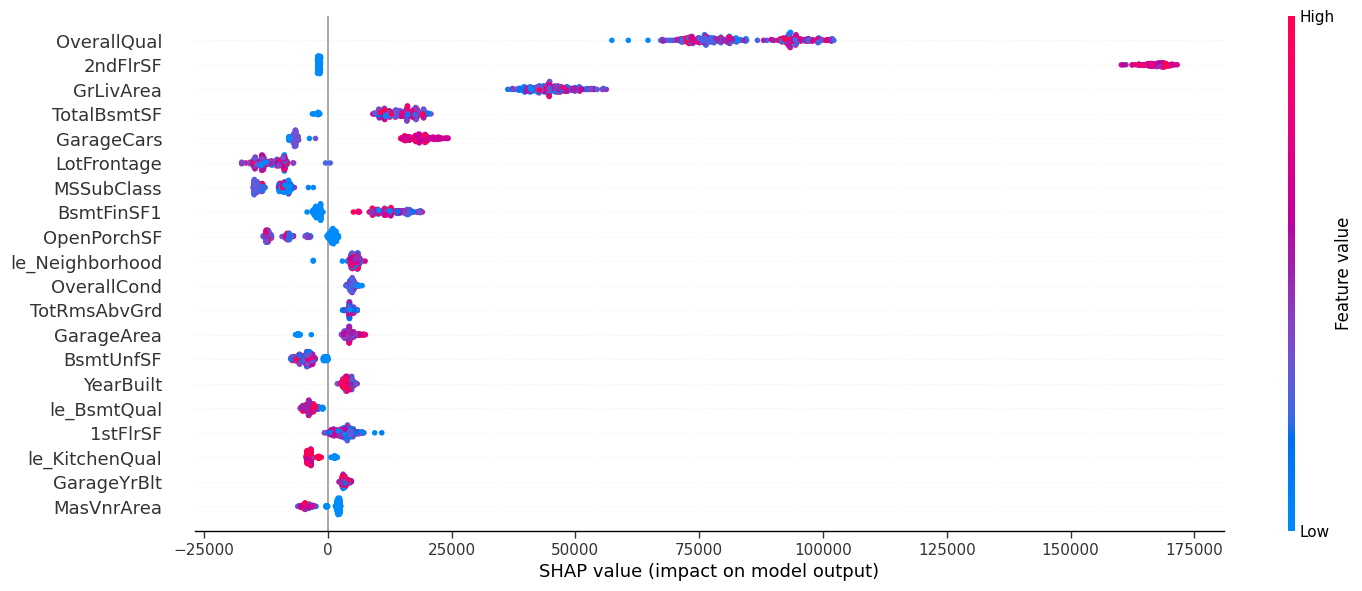

In [31]:
assert shap_values.shape[0] == X_oob.shape[0], "ERROR: Mismatch in number of samples!"
assert shap_values.shape[1] == X_oob.shape[1], "ERROR: Mismatch in number of features!"

# --- SHAP Summary Plot on Test Set Sample ---
shap.summary_plot(shap_values, X_oob, plot_size=(15, 6))

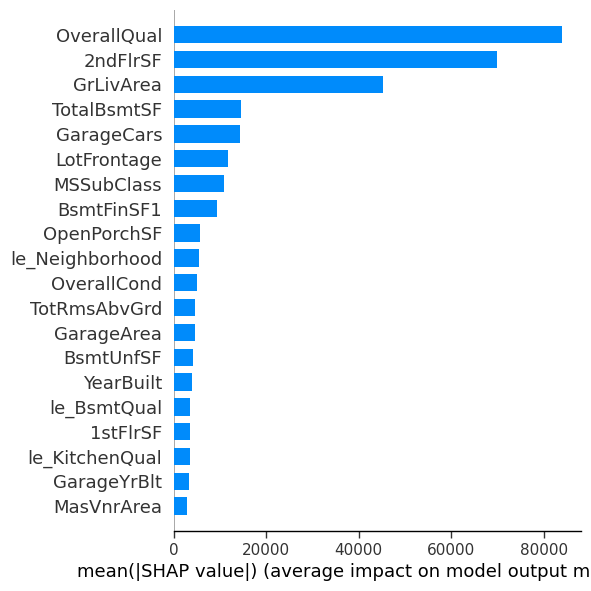

In [32]:
shap.summary_plot(shap_values, X_oob, plot_type='bar', plot_size=(6, 6))

In [33]:
shap.plots.force(explainer.expected_value, shap_values[0])

In [34]:
shap.plots.force(explainer.expected_value, shap_values[:100])

In [35]:
explanation = explainer(X_oob)

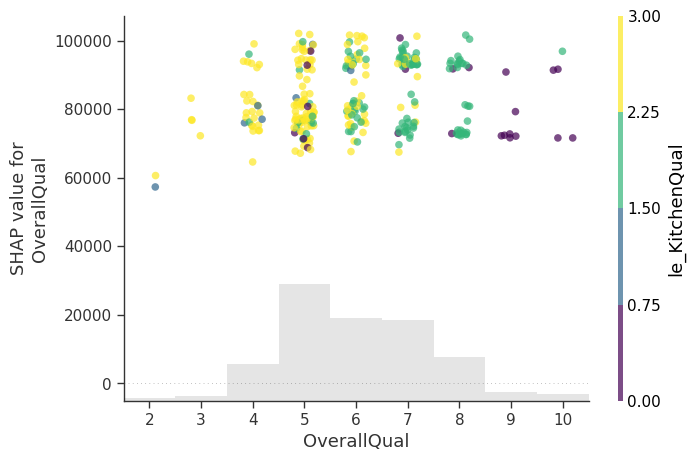

In [36]:
shap.plots.scatter(explanation[:, 'OverallQual'], color=explanation[:, 'le_KitchenQual'],
                  dot_size=30, alpha=0.7, x_jitter=0.4, cmap=plt.get_cmap('viridis'))

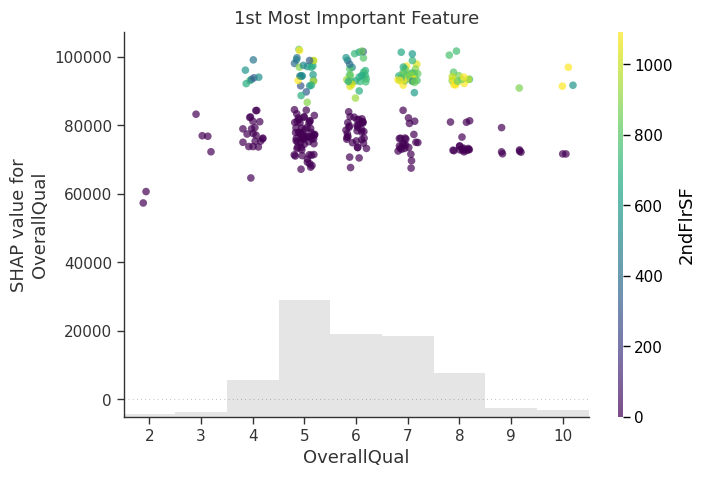

In [37]:
shap.plots.scatter(explanation[:, explanation.abs.mean(0).argsort[-1]], color=explanation,
                   title='1st Most Important Feature',
                   dot_size=30, alpha=0.7, x_jitter=0.4, cmap=plt.get_cmap('viridis'))

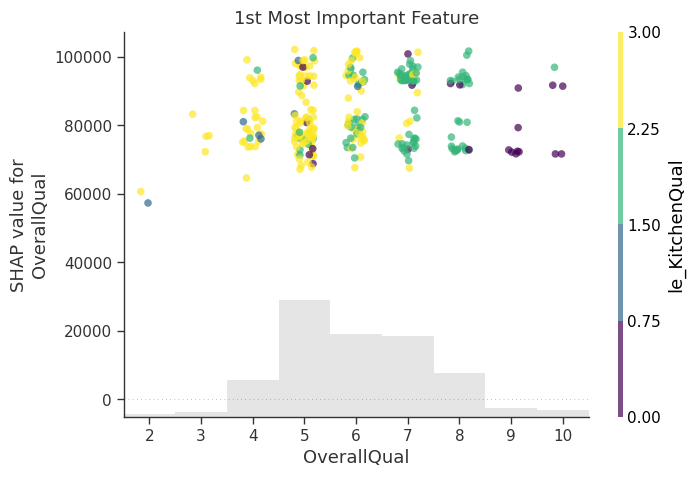

In [38]:
shap.plots.scatter(explanation[:, explanation.abs.mean(0).argsort[-1]], color=explanation[:, 'le_KitchenQual'],
                   title='1st Most Important Feature',
                   dot_size=30, alpha=0.7, x_jitter=0.4, cmap=plt.get_cmap('viridis'))

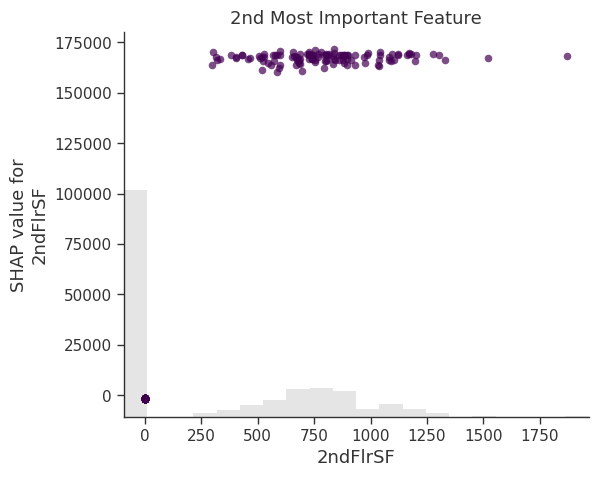

In [39]:
shap.plots.scatter(explanation[:, explanation.abs.mean(0).argsort[-2]], color=plt.get_cmap('viridis')(0.0),
                   title='2nd Most Important Feature',
                   dot_size=30, alpha=0.7)

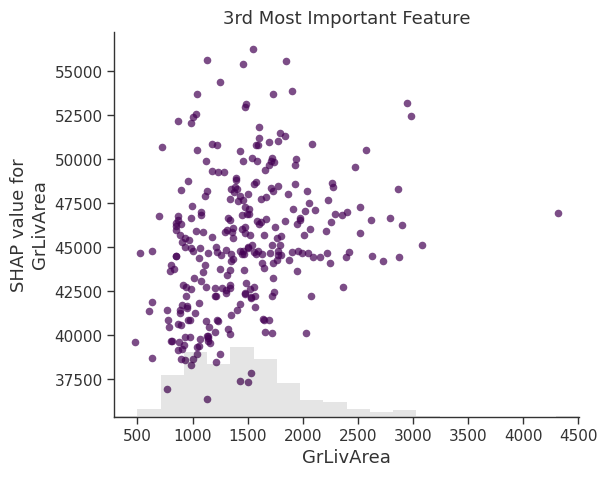

In [40]:
shap.plots.scatter(explanation[:, explanation.abs.mean(0).argsort[-3]], color=plt.get_cmap('viridis')(0.0),
                   title='3rd Most Important Feature', 
                   dot_size=30, alpha=0.7)

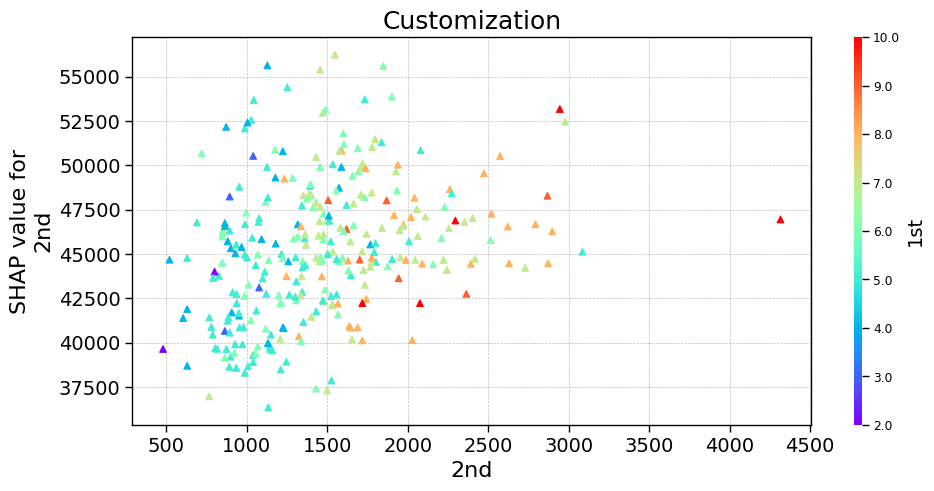

In [41]:
fig, ax = plt.subplots(tight_layout=True, figsize=(10, 5))

scatter = ax.scatter(
    explanation[:, explanation.abs.mean(0).argsort[-3]].data,
    explanation[:, explanation.abs.mean(0).argsort[-3]].values,
    c=explanation[:, explanation.abs.mean(0).argsort[-1]].data,
    marker="^",
    cmap=plt.get_cmap("rainbow"),
    rasterized=True,
    zorder=5,
)

cbar = plt.colorbar(scatter, aspect=50, format="%2.1f")
cbar.set_label(f"1st", fontsize=14)
cbar.outline.set_visible(False)

ax.set_title("Customization", fontsize=18)
ax.set_xlabel("2nd", fontsize=16)
ax.set_ylabel("SHAP value for\n2nd", fontsize=16)

ax.tick_params(labelsize=14)

ax.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)

plt.show()

In [42]:
differences = np.abs(y_oob_pred - y_oob)

closest_index = np.argmin(differences)
farthest_index = np.argmax(differences)

shap_values_closest = explainer.shap_values(X_oob.iloc[[closest_index]])
shap_values_farthest = explainer.shap_values(X_oob.iloc[[farthest_index]])

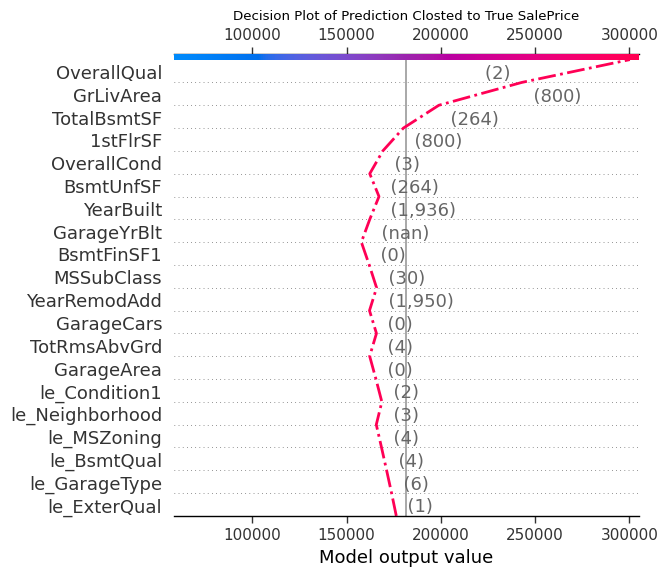

In [43]:
plt.figure(figsize=(6,6))

shap.decision_plot(explainer.expected_value, 
                   shap_values[closest_index],
                   X_oob.iloc[closest_index].values,
                   feature_names=features,
                   highlight=0,
                   title='Decision Plot of Prediction Closted to True SalePrice',
                   auto_size_plot=False)

plt.show()

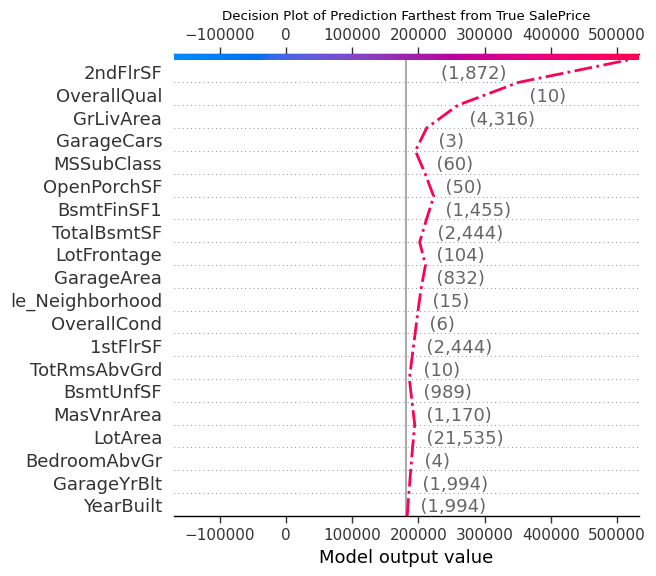

In [44]:
plt.figure(figsize=(6,6))

shap.decision_plot(explainer.expected_value, 
                   shap_values[farthest_index],
                   X_oob.iloc[farthest_index].values,
                   feature_names=features,
                   highlight=0,
                   title='Decision Plot of Prediction Farthest from True SalePrice',                   
                   auto_size_plot=False)

plt.show()

# Submission

In [45]:
houses_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
print(f"Rows: {houses_test.shape[0]:,}")
print(f"Cols: {houses_test.shape[1]:,}")
houses_test.head(3)

Rows: 1,459
Cols: 80


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [46]:
houses_test = handle_missing_values(houses_test, object_cols, strategy='fill_missing')

In [47]:
for obj_col in object_cols:
    le = le_result.get('label_encoder').get(obj_col)
    houses_test[f'le_{obj_col}'] = houses_test[obj_col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
houses_test[le_result.get('encoded_features')].head(3)    

,le_MSZoning,le_Street,le_Alley,le_LotShape,le_LandContour,le_Utilities,le_LotConfig,le_LandSlope,le_Neighborhood,le_Condition1,...,le_GarageType,le_GarageFinish,le_GarageQual,le_GarageCond,le_PavedDrive,le_PoolQC,le_Fence,le_MiscFeature,le_SaleType,le_SaleCondition
0,2,1,1,3,3,0,4,0,12,1,...,1,3,5,5,2,3,3,1,8,4
1,3,1,1,0,3,0,0,0,12,2,...,1,3,5,5,2,3,2,0,8,4
2,3,1,1,0,3,0,4,0,8,2,...,1,0,5,5,2,3,3,1,8,4


In [48]:
X_sub_scaled = preprocessing_pipeline.transform(houses_test[features])

In [49]:
y_sub_pred = xgb_model.predict(X_sub_scaled)

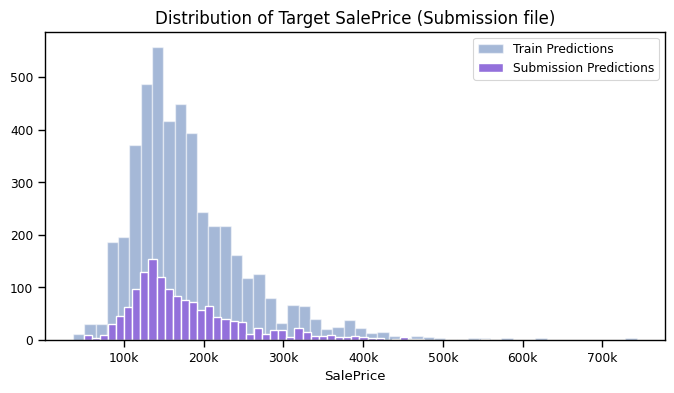

In [50]:
plt.figure(figsize=(8, 4))

plt.hist(train_predictions_clean, bins=50, edgecolor='white', linewidth=1, color='#4C72B0', alpha=0.5, label=f"Train Predictions")
plt.hist(y_sub_pred,              bins=50, edgecolor='white', linewidth=1, color='#9370DB', alpha=1.0, label=f"Submission Predictions");
plt.xlabel(TARGET)
plt.title("Distribution of Target SalePrice (Submission file)", fontsize=12)
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{int(y/1_000)}k'))

plt.show()

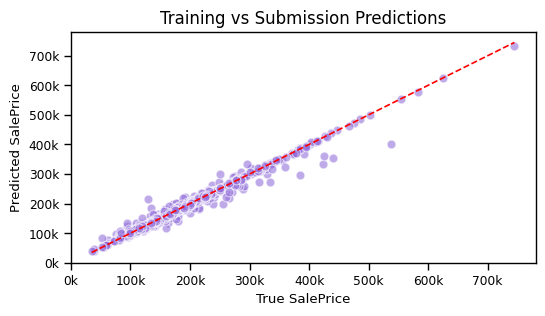

In [51]:
fig, axes = plt.subplots(figsize=(6, 3))

# --- Train Predictions vs Submission Predictions ---
axes.scatter(y_train, y_pred_train, color="#9370DB", alpha=0.6, s=40, edgecolor='white')
axes.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], '--', color='red')
axes.set_xlabel("True SalePrice")
axes.set_ylabel("Predicted SalePrice")

axes.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))

plt.title('Training vs Submission Predictions', fontsize=12)

plt.show()

In [52]:
submission_df = pd.DataFrame({
    ID: houses_test[ID],
    TARGET: y_sub_pred
})

submission_df.to_csv('/kaggle/working/submission.csv', index=False)
print(f"Submission file 'submission.csv' created successfully!")

submission_df

Submission file 'submission.csv' created successfully!


,Id,SalePrice
0,1461,128917.617188
1,1462,160078.015625
2,1463,174548.265625
3,1464,184576.656250
4,1465,194926.546875
...,...,...
1454,2915,87908.085938
1455,2916,90347.140625
1456,2917,170971.203125
1457,2918,118523.687500


---


💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏